In [1]:
using Revise
using LinearAlgebra
using SparseArrays
using Pkg
using DelayDiffEq 
using Plots
using BenchmarkTools

In [2]:
using OpenQuantumSystems

┌ Info: Precompiling OpenQuantumSystems [90e503ea-487f-4e8e-81fe-8dcc9db25ac5]
└ @ Base loading.jl:1342


In [3]:
D(op1::Array, op2::Array) = abs(norm(op1 - op2))
D(x1::StateVector, x2::StateVector) = norm(x2 - x1)
D(op1::AbstractOperator, op2::AbstractOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))
D(op1::AbstractSuperOperator, op2::AbstractSuperOperator) = abs(tracedistance_nh(dense(op1), dense(op2)))

HR = 0.01
shift = (2.0 * HR)
modes = [Mode(180., shift)]
mols = [
        Molecule([Mode(180., shift)], 3, [12500., 12700.]),
        Molecule([Mode(180., shift)], 3, [12500., 12700.])
    ]

aggCore = AggregateCore(mols)
for mol_i in 2:aggCore.molCount
    aggCore.coupling[mol_i, mol_i+1] = 50
    aggCore.coupling[mol_i+1, mol_i] = 50
end
agg = setupAggregate(aggCore)
aggCore = agg.core
aggTools = agg.tools
aggOperators = agg.operators

Ham_sys = agg.operators.Ham_sys
Ham_bath = agg.operators.Ham_bath
Ham_S = agg.operators.Ham_S
Ham_B = agg.operators.Ham_B
Ham_I = agg.operators.Ham_I
Ham_0 = agg.operators.Ham_0
Ham = agg.operators.Ham

basis = agg.tools.basis
indicesLen = agg.tools.bSize
indices = agg.tools.indices
indicesMap = agg.tools.indicesMap
FCFact = agg.tools.FCfactors
FCProd = agg.tools.FCproduct

Ham_0_lambda, Ham_0_S = eigen(Ham_0.data)
Ham_0_Sinv = inv(Ham_0_S)
Ham_0_lambda = diagm(Ham_0_lambda)

Ham_sys_lambda, Ham_sys_S = eigen(Ham_sys.data)
Ham_sys_Sinv = inv(Ham_sys_S)
Ham_sys_lambda = diagm(Ham_sys_lambda)
println("")

In [4]:
t_max = 0.1
t_count = 200
t0 = 0.
t_step = (t_max - t0) / (t_count)
tspan = [t0:t_step:t_max;]

T = 300
mu_array = [[2, 1]]
W0_1 = thermal_state(T, [[2, 1]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_2 = thermal_state(T, [[1, 2]], aggCore, aggTools, aggOperators; diagonalize = true)
W0_3 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
W0_4 = DenseOperator(W0_1.basis_l, W0_1.basis_r, zero(W0_1.data))
a1 = indicesMap[2][1]; a2 = indicesMap[2][end]
b1 = indicesMap[3][1]; b2 = indicesMap[3][end]
W0_3.data[a1:a2, b1:b2] = W0_2.data[b1:b2, b1:b2]
W0_4.data[b1:b2, a1:a2] = W0_2.data[b1:b2, b1:b2]
W0 = 0.8*W0_1 + 0.2*W0_2 + 0.1*W0_3 + 0.1*W0_4
W0 = DenseOperator(W0.basis_l, W0.basis_r, complex(W0.data))

# data = Matrix(Hermitian(rand(ComplexF64, indicesLen, indicesLen)))
# W0 = DenseOperator(basis, basis, data)
# normalize!(W0)

W0_bath = get_rho_bath(W0, aggCore, aggTools)
W0_bath = DenseOperator(W0_bath.basis_l, W0_bath.basis_r, complex(W0_bath.data))

rho0 = trace_bath(W0, aggCore, aggTools)
rho0 = DenseOperator(rho0.basis_l, rho0.basis_r, complex(rho0.data))

println("")

In [10]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time T, rho_int_t2 = QME_sI_ansatz_const(
    W0,
    tspan,
    agg;
    reltol = 1e-6,
    abstol = 1e-6,
    int_reltol = 1e-7,
    int_abstol = 1e-7,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

 15.731268 seconds (24.71 M allocations: 3.145 GiB, 3.65% gc time, 3.12% compilation time)


([0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045  …  0.0955, 0.096, 0.0965, 0.097, 0.0975, 0.098, 0.0985, 0.099, 0.0995, 0.1], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im        0.0+0.0im
 0.0+0.0im   0.799839+0.0im  0.0999399+0.0im
 0.0+0.0im  0.0999399+0.0im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im                0.0+0.0im
 0.0+0.0im   0.799839-0.0im          0.0999399-9.03662e-11im
 0.0+0.0im  0.0999399+9.03662e-11im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im                0.0+0.0im
 0.0+0.0im   0.799839+0.0im          0.0999399-7.20273e-10im
 0.0+0.0im  0.0999399+7.20273e-10im    0.19996-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799839-0.0im         0.0999399-2.38021e-9im
 0.0+0.0im  0.0999

In [6]:
BenchmarkTools.DEFAULT_PARAMETERS.samples = 5
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 60
using OpenQuantumSystems
@time T, rho_int_t = QME_sI_ansatz_linear2(
    W0,
    tspan,
    agg;
    reltol = 1e-6,
    abstol = 1e-6,
    int_reltol = 1e-7,
    int_abstol = 1e-7,
    t_mk_bath_step = 1e-4,
    alg = DelayDiffEq.MethodOfSteps(DelayDiffEq.Tsit5()),
)

 76.739218 seconds (99.86 M allocations: 55.066 GiB, 8.89% gc time)


([0.0, 0.0005, 0.001, 0.0015, 0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045  …  0.0955, 0.096, 0.0965, 0.097, 0.0975, 0.098, 0.0985, 0.099, 0.0995, 0.1], Operator{GenericBasis{Vector{Int64}}, GenericBasis{Vector{Int64}}, Matrix{ComplexF64}}[Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im        0.0+0.0im
 0.0+0.0im   0.799839+0.0im  0.0999399+0.0im
 0.0+0.0im  0.0999399+0.0im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im                0.0+0.0im
 0.0+0.0im   0.799839-0.0im          0.0999399-9.03662e-11im
 0.0+0.0im  0.0999399+9.03662e-11im    0.19996+0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im                0.0+0.0im
 0.0+0.0im   0.799839+0.0im          0.0999399-7.20273e-10im
 0.0+0.0im  0.0999399+7.20273e-10im    0.19996-0.0im, Operator(dim=3x3)
  basis: Basis(dim=3)
 0.0+0.0im        0.0+0.0im               0.0+0.0im
 0.0+0.0im   0.799839-0.0im         0.0999399-2.38021e-9im
 0.0+0.0im  0.0999

In [7]:
W_t_exact = zeros(ComplexF64, length(tspan), agg.tools.bSize, agg.tools.bSize)
t_i = 0

for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham, t)
    W = U_op * W0 * U_op'
    U_0_op = evolutionOperator(Ham_0, t)
    W = U_0_op' * W * U_0_op
    W_t_exact[t_i, :, :] = W.data
end

1 0.0
2 4.2069771483683533e-14
3 1.5871003969563492e-14
4 6.269123568170313e-11
5 2.214646312139581e-10
6 3.5524254064371205e-10
7 4.0407787130088114e-10
8 3.587052808191882e-10
9 2.482303473157039e-10
10 1.4582644825973571e-10
11 1.6558669520034708e-10
12 2.2369917960701598e-10
13 2.230732335536245e-10
14 1.5440544564604224e-10
15 5.830329527017458e-11
16 4.067869535565378e-11
17 1.3858497077143636e-9
18 3.9353489884831144e-9
19 6.923817616509027e-9
20 9.774712724429083e-9
21 1.2080050883283313e-8
22 1.3583291776186332e-8
23 1.4161339504180691e-8
24 1.3806163620860708e-8
25 1.260721468178561e-8
26 1.0737273916338622e-8
27 8.449808753146114e-9
28 6.114449810363319e-9
29 4.364631218931757e-9
30 4.095237139104824e-9
31 5.111074775187016e-9
32 6.313762834384559e-9
33 7.114265343382291e-9
34 7.304792761284028e-9
35 6.854551881832667e-9
36 5.851884288886589e-9
37 4.4906312259098075e-9
38 3.067619132810303e-9
39 1.982185845080958e-9
40 1.7923588647459166e-9
41 3.845101366371156e-9
42 7.79438

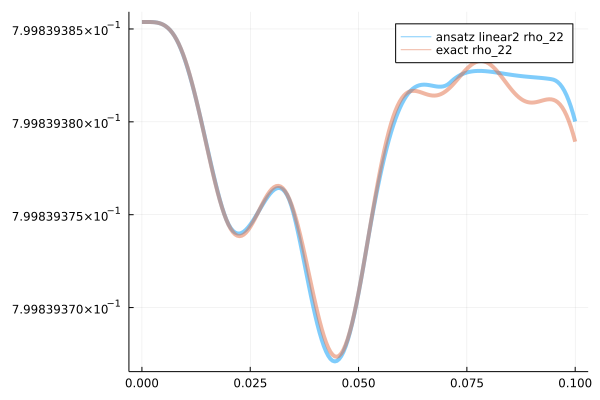

In [11]:

elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t2 = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)

for t_i in 1:length(tspan)
    rho_t[t_i, :, :] = rho_int_t[t_i].data
    rho_t2[t_i, :, :] = rho_int_t2[t_i].data
    rho_t_exact[t_i, :, :] = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t2[:, 2, 2]), label="ansatz constant rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot(tspan, real(rho_t[:, 2, 2]), label="ansatz linear2 rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

(27, 27)
1 0.0
2 4.2059194973661215e-14
3 1.5879048198861808e-14
4 6.269126158753903e-11
5 2.2146463275168907e-10
6 3.552425457485899e-10
7 4.04077886791e-10
8 3.587052723746149e-10
9 2.482303544134632e-10
10 1.4582641947439882e-10
11 1.655865939152462e-10
12 2.2369905249270805e-10
13 2.2307333996678472e-10
14 1.544054757707513e-10
15 5.830327294945407e-11
16 4.067877829383128e-11
17 1.385849626495555e-9
18 3.935348979386282e-9
19 6.92381768626435e-9
20 9.77471264442233e-9
21 1.2080050836787254e-8
22 1.3583291778515395e-8
23 1.4161339397509466e-8
24 1.3806163613251907e-8
25 1.260721474771916e-8
26 1.0737273954775619e-8
27 8.449808728850832e-9
28 6.114449842024449e-9
29 4.364631254825482e-9
30 4.095237100175624e-9
31 5.111074818795375e-9
32 6.31376280076243e-9
33 7.1142654167788586e-9
34 7.304792744287833e-9
35 6.854551856822501e-9
36 5.8518841444708265e-9
37 4.490631256165247e-9
38 3.067619063411803e-9
39 1.982185910453057e-9
40 1.792358862139348e-9
41 3.845101374404305e-9
42 7.7943850

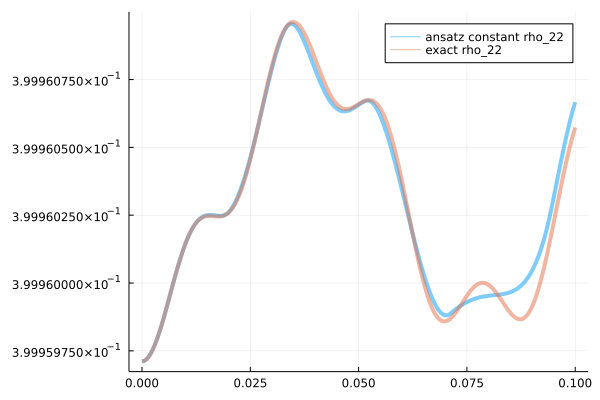

In [9]:
elLen = aggCore.molCount
rho_t = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
rho_t_exact = zeros(ComplexF64, length(tspan), elLen+1, elLen+1)
println(size(Ham_0_Sinv))
for t_i in 1:length(tspan)
    t = tspan[t_i]
    U_op = evolutionOperator(Ham_sys, t)
    rho_t[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho_int_t[t_i].data * U_op.data * Ham_sys_S
    rho = trace_bath(W_t_exact[t_i, :, :], aggCore, aggTools)
    rho_t_exact[t_i, :, :] = Ham_sys_Sinv * (U_op').data * rho * U_op.data * Ham_sys_S
    println(t_i, " ", D(rho_t[t_i, :, :], rho_t_exact[t_i, :, :]))
end

plot(tspan, real(rho_t[:, 2, 2]), label="ansatz linear2 rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot(tspan, real(rho_t[:, 2, 2]), label="ansatz constant rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)
plot!(tspan, real(rho_t_exact[:, 2, 2]), label="exact rho_22", linealpha = 0.5, linewidth = 4, linestyle = :solid)

In [27]:
using OpenQuantumSystems
include("test_master_ansatz.jl")


Test Summary: |
master ansatz | No tests


Test.DefaultTestSet("master ansatz", Any[], 0, false, false)

In [71]:
names = [
    "test_operators_dense.jl",
    "test_superoperators.jl",
    "test_metrics.jl",
    "test_molecules.jl",
    "test_aggregateCore.jl",
    "test_aggregateTools.jl",
    "test_aggregateOperators.jl",
    "test_aggregate.jl",
    "test_evolution.jl",
    "test_schroedinger.jl",
    "test_liouville.jl",
    "test_interaction_picture.jl",
    "test_master_exact.jl",
    "test_trace.jl",
    "test_initial_state.jl",
    "test_memory_kernel.jl",
    "test_master_ansatz.jl",
]

for name in names
    include(name)
end

Test Summary:   | Pass  Total
operators dense |    6      6
Test Summary:  | Pass  Total
superoperators |    2      2
Test Summary: | Pass  Total
metrics       |   19     19
Test Summary: | Pass  Total
molecules     |   20     20
Test Summary: | Pass  Total
aggregateCore |   14     14
Test Summary:  | Pass  Total
aggregateTools |   12     12
Test Summary:      | Pass  Total
aggregateOperators |    7      7
Test Summary: | Pass  Total
aggregate     |    3      3
Test Summary: | Pass  Total
evolution     |   54     54
Test Summary: | Pass  Total
schroedinger  |   25     25
Test Summary: | Pass  Total
liouville     |   33     33
Test Summary:       | Pass  Total
interaction picture |   12     12
Test Summary: |
master        | No tests
Test Summary: | Pass  Total
trace         |   41     41
Test Summary: | Pass  Total
initial state |    8      8
Test Summary: | Pass  Total
memory kernel |   51     51
Test Summary: |
master ansatz | No tests
